In [1]:
import pickle
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']
dims = [('sincere','exciting'),
        ('hedonic','utilitarian'),
        ('masculine','feminine'),
        ('tasty','nutritious'),
        ('significance','autonomy'),
        ('dread-inducing','unknowable'),
        ('warm', 'competent')]

# domains = ['trait']
# dims = [('masculine', 'feminine')]

dim_names_flattened = [x for dim_pair in dims for x in dim_pair]

In [3]:
# dim_vecs_df = pd.read_csv('data/word2vec_similarity_dim_vecs.csv', index_col=0)
dim_vecs_df = pd.read_csv('data/word2vec_similarity_alt_gender_dim_vecs.csv', index_col=0)
# dim_vecs_df = pd.read_csv('data/paragram_similarity_dim_vecs.csv', index_col=0)
dim_vecs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
sincere,-0.090576,0.056602,-0.059738,0.230011,0.081116,0.090279,0.228943,-0.005371,-0.083893,-0.082916,...,-0.096397,-0.038284,0.026642,-0.122517,-0.019836,0.098328,0.054337,-0.051895,0.130005,-0.097415
exciting,-0.134979,-0.131195,-0.031158,-0.109253,0.154205,-0.242981,-0.252869,0.102875,-0.137268,-0.061630,...,0.025345,-0.081116,-0.119629,-0.248619,0.087677,-0.021038,-0.006592,-0.044891,0.047729,-0.097046
hedonic,-0.094686,-0.138184,-0.052444,-0.001607,0.130692,-0.265666,-0.163249,0.034688,-0.263947,0.026693,...,0.022400,-0.000488,-0.030711,-0.190470,0.060465,-0.013041,0.049377,-0.024394,0.098256,-0.171712
utilitarian,-0.153661,-0.243525,-0.179016,-0.005483,0.156576,-0.251504,-0.033610,0.030248,-0.071508,-0.213359,...,-0.204427,-0.147685,0.080009,-0.008789,0.112905,0.175964,0.139882,-0.102478,0.159098,-0.065104
masculine,-0.103109,0.088967,0.124990,-0.216858,0.165080,-0.187937,-0.153849,0.115448,-0.010559,-0.054955,...,0.028158,-0.133870,0.070394,-0.058451,0.039907,0.012098,-0.149007,-0.273158,0.033691,0.016154


In [4]:
with open("data/dict_of_Xs.pickle", "rb") as handle:
    dict_of_Xs = pickle.load(handle)

# with open("data/dict_of_Xs_paragram.pickle", "rb") as handle:
#     dict_of_Xs = pickle.load(handle)

with open("data/dict_of_ys.pickle", "rb") as handle:
    dict_of_ys = pickle.load(handle)

In [5]:
dict_of_Xs.keys()

dict_keys(['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people'])

# Modeling means

In [6]:
# correlation_results = []

regr = LinearRegression()

for domain, dim_pair in zip(domains, dims):
    X = dict_of_Xs[domain]
    for dim in dim_pair:
        dim_vec = dim_vecs_df.loc[dim].values
        dot_products = X.applymap(float).dot(dim_vec).to_frame()
        y = dict_of_ys[dim]
        y.name = f'actual_{dim}'

        y_preds = np.zeros(shape=len(y))
        loo = LeaveOneOut()
        for train_index, test_index in loo.split(dot_products):
            dot_products_train, dot_products_test = dot_products.iloc[train_index], dot_products.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            regr.fit(X=dot_products_train, y=y_train)
            y_pred = regr.predict(X=dot_products_test)
            y_preds[test_index] = y_pred
            
        preds_and_actual =  pd.DataFrame({f'Actual {dim}':y, f'Predicted {dim}':y_preds}, index=dict_of_ys[dim].index)
        preds_and_actual.to_csv(f'results/grand_method_actual_vs_pred/{dim}.csv')                      
#         preds_and_actual.to_csv(f'results/grand_method_actual_vs_pred_paragram/{dim}.csv')                      
#         dot_products = pd.Series(dot_products, name=f'predicted_{dim}')

#         sns.jointplot(x=dot_products, y=y)
#         plt.savefig(f'figures/pred_v_actual_scatterplots_grand_et_al/{dim}.png')
#         plt.show()
        
#         r, p = pearsonr(dot_products, y)
#         correlation_results.append((r,p, r**2))
        
# correlation_results = pd.DataFrame(correlation_results, index=dim_names_flattened, columns=['r','p','rsquared'])
# correlation_results.to_csv('results/grand_et_al_method.csv', float_format='%.4f')

# Modeling individuals

In [7]:
with open("data/dict_of_individual_ys.pickle", "rb") as handle:
    dict_of_individual_ys = pickle.load(handle)

In [8]:
regr = LinearRegression()

In [9]:
dict_of_individual_similarity_y_preds = dict()

In [10]:
for domain, dim_pair in tqdm(zip(domains, dims)):
    X = dict_of_Xs[domain]
    for dim in dim_pair:
        dim_vec = dim_vecs_df.loc[dim].values
        dot_products = X.applymap(float).dot(dim_vec).to_frame()
        
        all_individual_preds = np.zeros(shape=dict_of_individual_ys[dim].shape)
        for individual_idx, y in enumerate(dict_of_individual_ys[dim].values):
            y_preds = np.zeros(shape=len(y))
            loo = LeaveOneOut()
            for train_index, test_index in loo.split(dot_products):
                X_train = dot_products.iloc[train_index] 
                X_test  = dot_products.iloc[test_index]
                y_train = y[train_index].astype(float)
                
                y_notna_idxs = ~np.isnan(y_train)
                y_train = y_train[y_notna_idxs]
                X_train = X_train[y_notna_idxs]
                
                regr.fit(X=X_train, y=y_train)
                y_pred = regr.predict(X=X_test)[0]
                y_preds[test_index] = y_pred
            all_individual_preds[individual_idx] = y_preds
        individual_predictions = pd.DataFrame(all_individual_preds, 
                                              columns=dict_of_individual_ys[dim].columns)
        dict_of_individual_similarity_y_preds[dim] = individual_predictions

7it [01:38, 14.06s/it]


In [11]:
with open("results/dict_of_individual_similarity_y_preds.pickle", "wb") as handle:
# with open("results/dict_of_individual_similarity_y_preds_paragram.pickle", "wb") as handle:
    pickle.dump(dict_of_individual_similarity_y_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute and visualize individual-level actual vs pred correlations

In [12]:
if 'dict_of_individual_similarity_y_preds' not in globals():
    with open("results/dict_of_individual_similarity_y_preds.pickle", "rb") as handle:
#     with open("results/dict_of_individual_similarity_y_preds_paragram.pickle", "rb") as handle:
        dict_of_individual_similarity_y_preds = pickle.load(handle)

In [13]:
all_participant_rs = []
dims = dict_of_individual_ys.keys()
for dim in dims:
    df_ys      = dict_of_individual_ys[dim]
    df_y_preds = dict_of_individual_similarity_y_preds[dim]
    dim_rs = []
    for ys, y_preds in zip(df_ys.values, df_y_preds.values):
        y_not_na_idx = ~np.isnan(ys.astype(float))

        ys_not_na      = ys[y_not_na_idx]
        y_preds_not_na = y_preds[y_not_na_idx]
        
        r, _ = pearsonr(ys_not_na, y_preds_not_na)
        dim_rs.append(r)
    all_participant_rs.append(dim_rs)
all_participant_rs_df = pd.DataFrame(all_participant_rs, index=dims).T

In [14]:
all_participant_rs_df_stacked = all_participant_rs_df.stack().reset_index()
all_participant_rs_df_stacked.columns = ['participant_number', 'Judgment Dimension', 'Correlation of Pred vs Actual']

In [15]:
all_participant_rs_df_stacked.groupby('Judgment Dimension').mean().abs().mean()

participant_number               17.357143
Correlation of Pred vs Actual     0.211052
dtype: float64

In [16]:
all_participant_rs_df_stacked.to_csv('results/individual-level_similarity_model_results.csv')

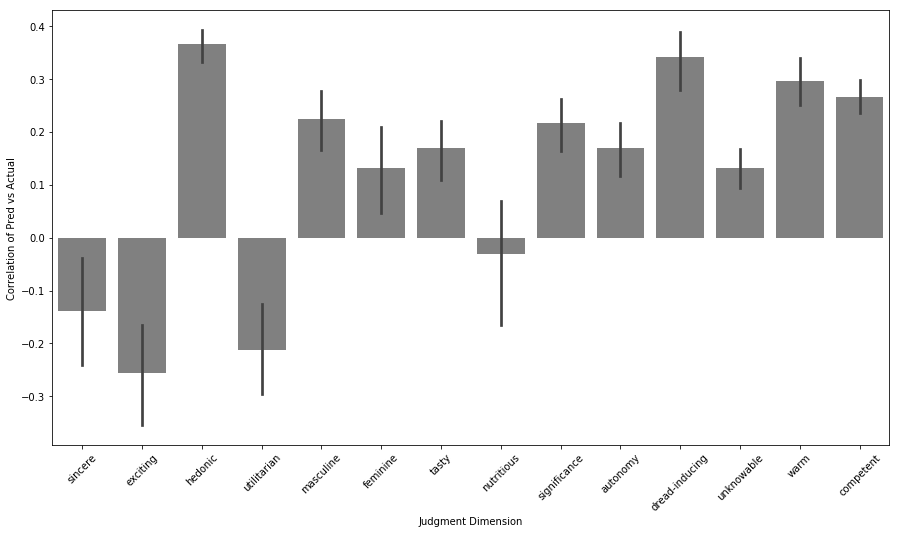

In [17]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45);
sns.barplot(data=all_participant_rs_df_stacked, x='Judgment Dimension', y='Correlation of Pred vs Actual', color='gray');
plt.savefig('figures/individual_level_similarity_pred_v_actual_correlation_barplots.png')
# plt.savefig('figures/individual_level_similarity_pred_v_actual_correlation_barplots_paragram.png')